# Time-Dependent SIR Model

Adapted from https://arxiv.org/abs/2003.00122

Shoutout to Ping-En Lu and team for providing source code

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

from datetime import timedelta
import math

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi']= 600
sns.set()

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [2]:
# Helper functions
def data_split(data, orders, start):
    x_train = np.empty((len(data) - start - orders, orders))
    y_train = data[start + orders:]

    for i in range(len(data) - start - orders):
        x_train[i] = data[i + start:start + orders + i]

    # Exclude the day (Feb. 12, 2020) of the change of the definition of confirmed cases in Hubei China.
    x_train = np.delete(x_train, np.s_[28 - (orders + 1) - start:28 - start], 0)
    y_train = np.delete(y_train, np.s_[28 - (orders + 1) - start:28 - start])

    return x_train, y_train


def ridge(x, y):
    print('\nStart searching good parameters for the task...')
    parameters = {'alpha': np.arange(0, 0.100005, 0.000005).tolist(),
                  "tol": [1e-8],
                  'fit_intercept': [True, False],
                  'normalize': [True, False]}

    clf = GridSearchCV(Ridge(), parameters, n_jobs=-1, cv=5)
    clf.fit(x, y)

    print('\nResults for the parameters grid search:')
    print('Model:', clf.best_estimator_)
    print('Score:', clf.best_score_)

    return clf


def clean_df(df_metric, country='US', metric='Confirmed', start_date = '2020-01-22'):
    dropCols = ['Province/State', 'Country/Region','Lat','Long']
    df = df_metric[df_metric['Country/Region'] == country].drop(dropCols,axis=1).T.reset_index()
    df.columns = ['Date',metric]
    df['Date'] = pd.to_datetime(df.Date).dt.date
    
    df['EpidemicStartDate'] = df.sort_values(by='Date').loc[df[metric]!=0].Date.iloc[0]
    df['DaysElapsed'] = (df.Date - df.EpidemicStartDate).dt.days + 1

    return df[['Date','DaysElapsed',metric]].loc[df.Date >= pd.to_datetime(start_date)]

In [3]:
# Read in data from Johns Hopkins CSSE for US
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
deaths_df    = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

start_date   = '2020-03-01'
X_cml        = np.array(clean_df(confirmed_df, 'US', 'Confirmed', start_date).Confirmed, dtype=np.float64)
recovered    = np.array(clean_df(recovered_df, 'US', 'Recovered', start_date).Recovered, dtype=np.float64)
death        = np.array(clean_df(deaths_df,    'US', 'Deaths',    start_date).Deaths,    dtype=np.float64)

population   = 329500000

In [4]:
# Data for China
X_cml = np.array([41, 45, 62, 121, 199, 291, 440, 574, 835, 1279, 1985, 2761, 4535, 5997, 7736, 9720, 11821, 14411, 17238, 20471, 24363, 28060, 31211, 34598, 37251, 40235, 42708, 44730, 59882, 63932, 66576, 68584, 70635, 72528, 74279, 75101, 75993, 76392, 77041, 77262, 77779, 78190, 78630, 78959, 79389, 79968, 80174, 80302, 80422, 80565, 80710, 80813, 80859, 80904, 80924, 80955, 80980, 81003, 81201, 81048, 81077, 81116, 81151, 81235, 81300, 81416, 81498, 81600, 81747, 81846, 81960, 82078, 82213, 82341, 82447, 82545, 82631, 82724, 82802, 82875, 82930, 83005, 83071, 83157, 83249], dtype=np.float64)[:-27]
recovered = np.array([12, 12, 16, 21, 25, 25, 28, 28, 34, 38, 49, 51, 60, 103, 124, 171, 243, 328, 475, 632, 892, 1153, 1540, 2050, 2651, 3283, 3998, 4742, 5915, 6728, 8101, 9425, 10853, 12561, 14387, 16170, 18279, 20673, 22907, 24757, 27353, 29775, 32531, 36157, 39049, 41675, 44518, 47260, 49914, 52109, 53793, 55477, 57143, 58684, 59982, 61567, 62887, 64216, 65649, 67022, 67863, 68799, 69725, 70547, 71284, 71876, 72382, 72841, 73299, 73791, 74196, 74737, 75122, 75600, 75937, 76225, 76415, 76610, 76785, 76984, 77210, 77348, 77450, 77586, 77711], dtype=np.float64)[:-27]
death = np.array([2, 3, 3, 3, 4, 6, 9, 18, 25, 41, 56, 80, 106, 132, 170, 213, 259, 304, 361, 425, 491, 564, 637, 723, 812, 909, 1017, 1114, 1368, 1381, 1524, 1666, 1772, 1870, 2006, 2121, 2239, 2348, 2445, 2595, 2666, 2718, 2747, 2791, 2838, 2873, 2915, 2946, 2984, 3015, 3045, 3073, 3100, 3123, 3140, 3162, 3173, 3180, 3194, 3204, 3218, 3231, 3242, 3250, 3253, 3261, 3267, 3276, 3283, 3287, 3293, 3298, 3301, 3306, 3311, 3314, 3321, 3327, 3331, 3335, 3338, 3340, 3340, 3342, 3344], dtype=np.float64)[:-27]

population = 1439323776

In [5]:
# Preprocessing
X = X_cml - recovered - death
R = recovered + death

n = np.array([population] * len(X), dtype=np.float64)

S = n - X - R

gamma = np.diff(R) / X[:-1]
beta = (np.diff(X) + np.diff(R))/X[:-1]
R0 = beta / gamma

print("The latest transmission rate (beta) of SIR model:", beta[-1])
print("The latest recovering rate (gamma) of SIR model:", gamma[-1])
print("The latest basic reproduction number R0:", round(R0[-1],3))

The latest transmission rate (beta) of SIR model: 0.0015415549597855229
The latest recovering rate (gamma) of SIR model: 0.08954423592493298
The latest basic reproduction number R0: 0.017


In [6]:
########## Parameters for Ridge Regression ##########
##### Orders of the two FIR filters in (12), (13) in the paper. #####
orders_beta = 3
orders_gamma = 3

##### Select a starting day for the data training in the ridge regression. #####
start_beta = 10
start_gamma = 10

########## Ridge Regression ##########
##### Split the data to the training set and testing set #####

# EACH X OBSERVATION IS THE SET OF 3 PREVIOUS Y OBSERVATIONS (Y_t-1, Y_t-2, ... , Y_t-3) AS FEATURES TO PREDICT Y_t

x_beta, y_beta = data_split(beta, orders_beta, start_beta)
x_gamma, y_gamma = data_split(gamma, orders_gamma, start_gamma)

##### Searching good parameters #####
# clf_beta = ridge(x_beta, y_beta)
# clf_gamma = ridge(x_gamma, y_gamma)

##### Training and Testing W/ Ridge Regression #####
clf_beta = Ridge(alpha=0.003765, copy_X=True, fit_intercept=False, max_iter=None, normalize=True, random_state=None, solver='auto', tol=1e-08).fit(x_beta, y_beta)
clf_gamma = Ridge(alpha=0.001675, copy_X=True, fit_intercept=False, max_iter=None, normalize=True, random_state=None, solver='auto', tol=1e-08).fit(x_gamma, y_gamma)

beta_hat = clf_beta.predict(x_beta)
gamma_hat = clf_gamma.predict(x_gamma)

In [7]:
x_beta.shape

(40, 3)

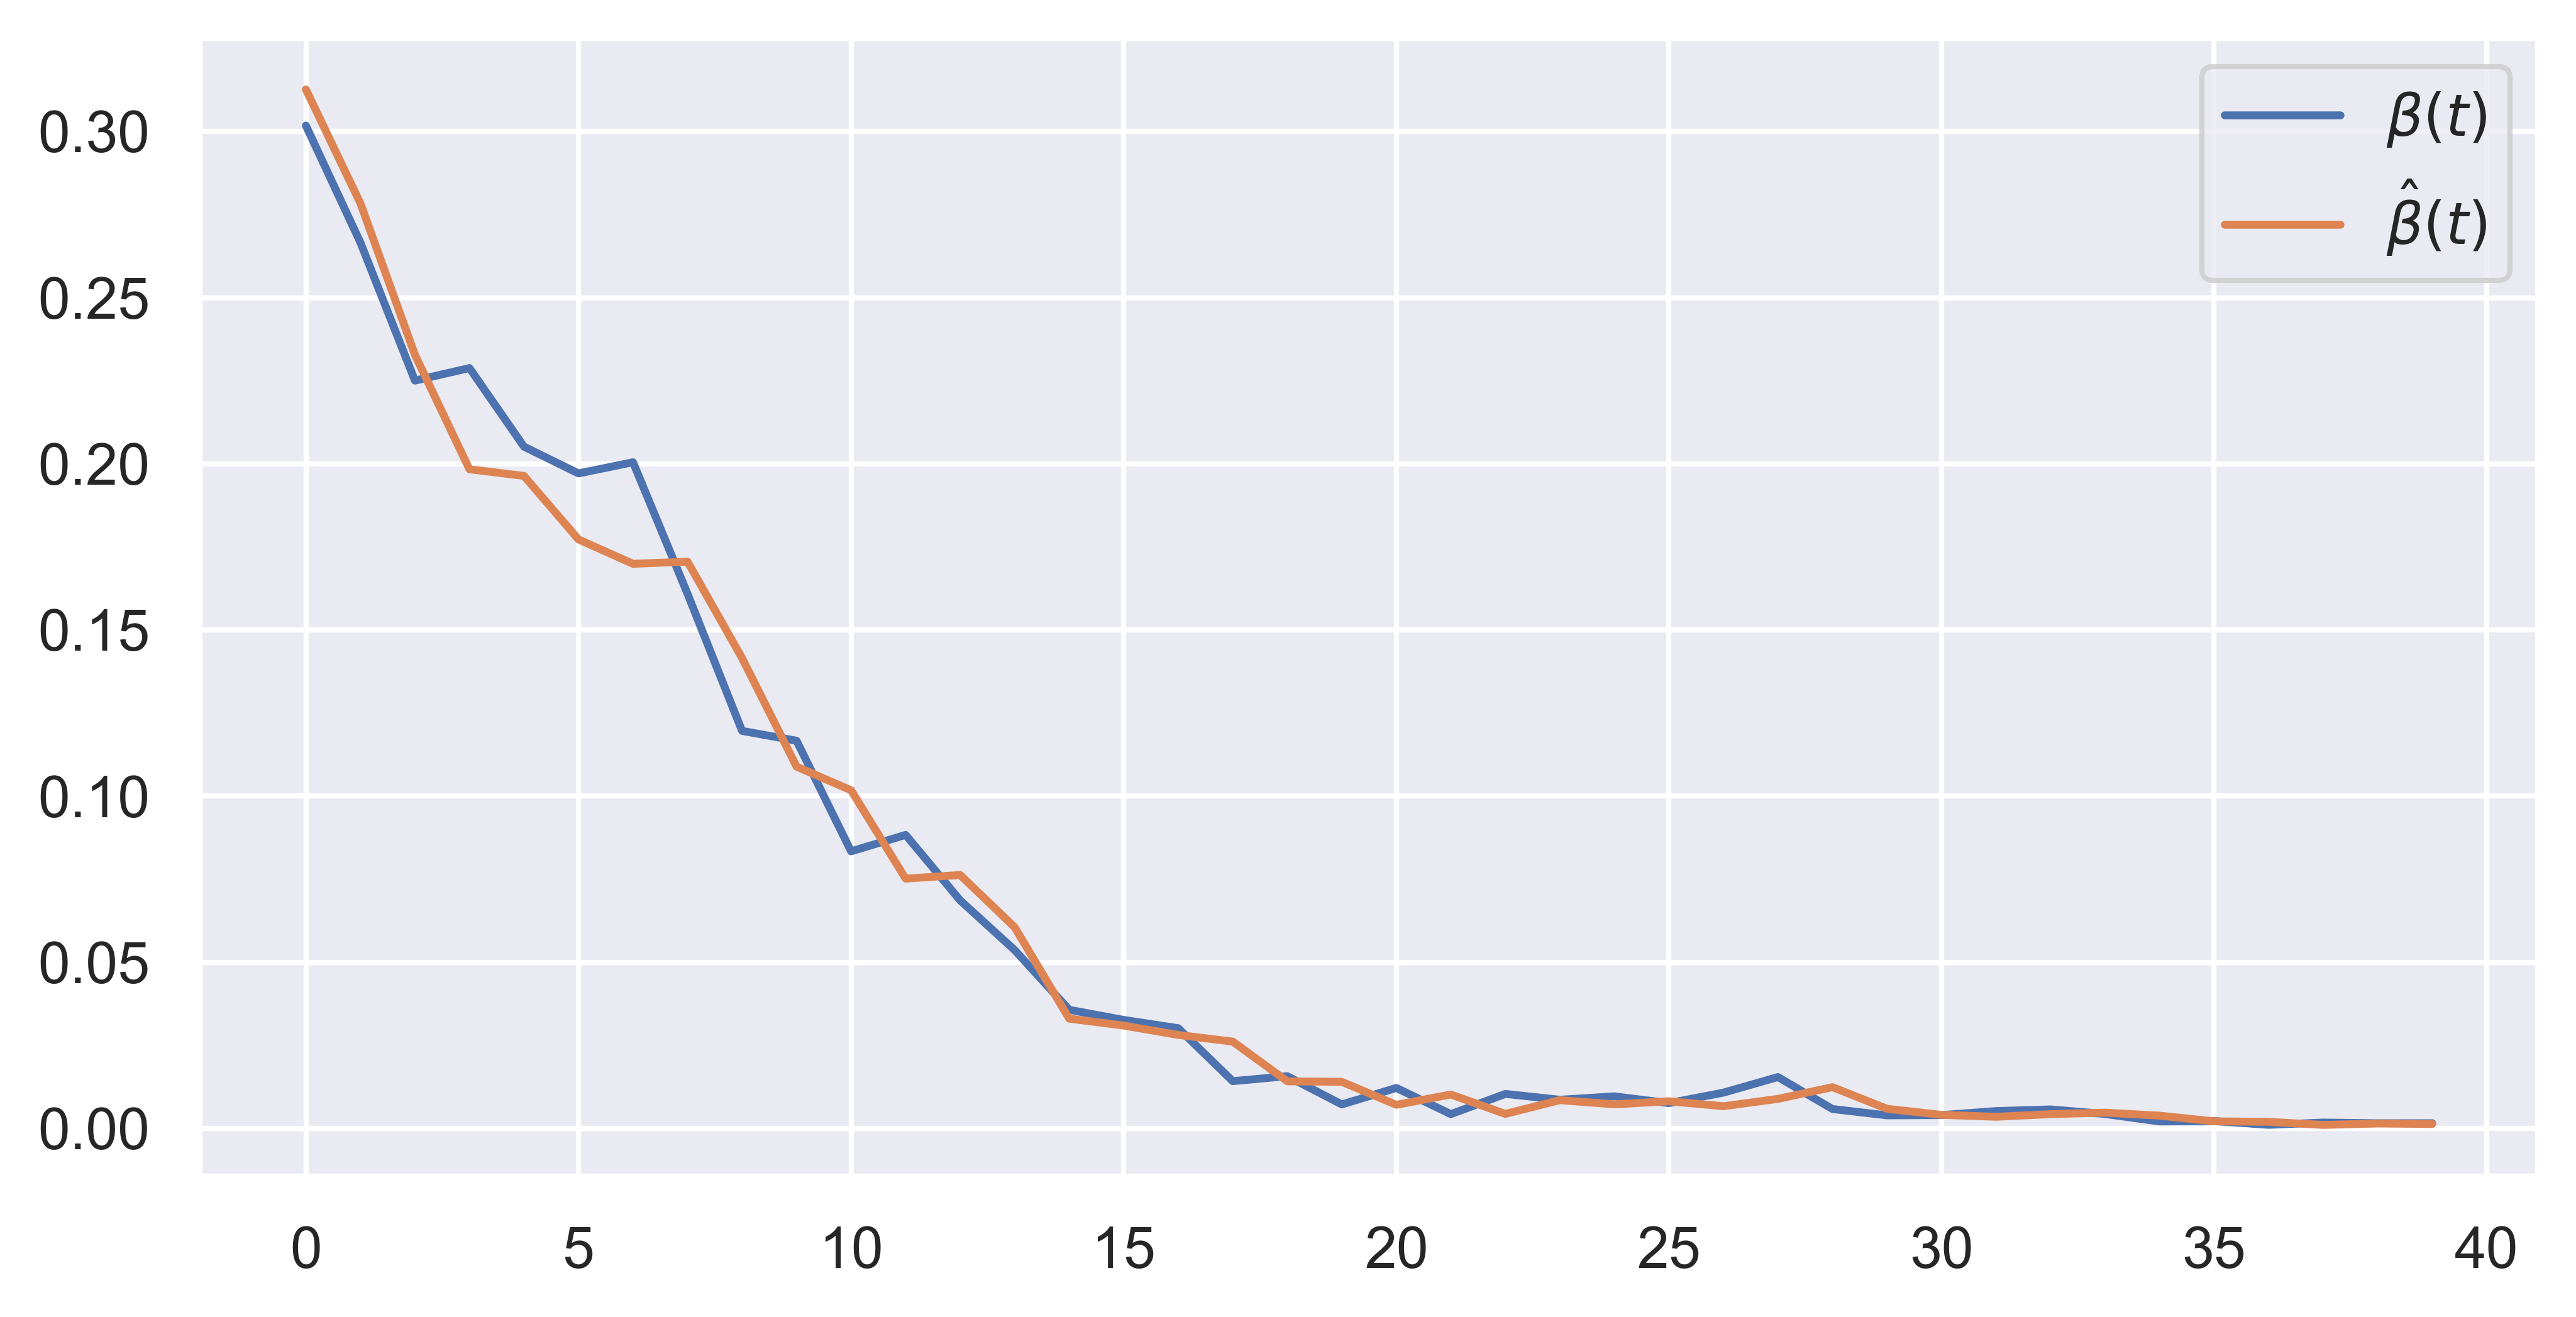

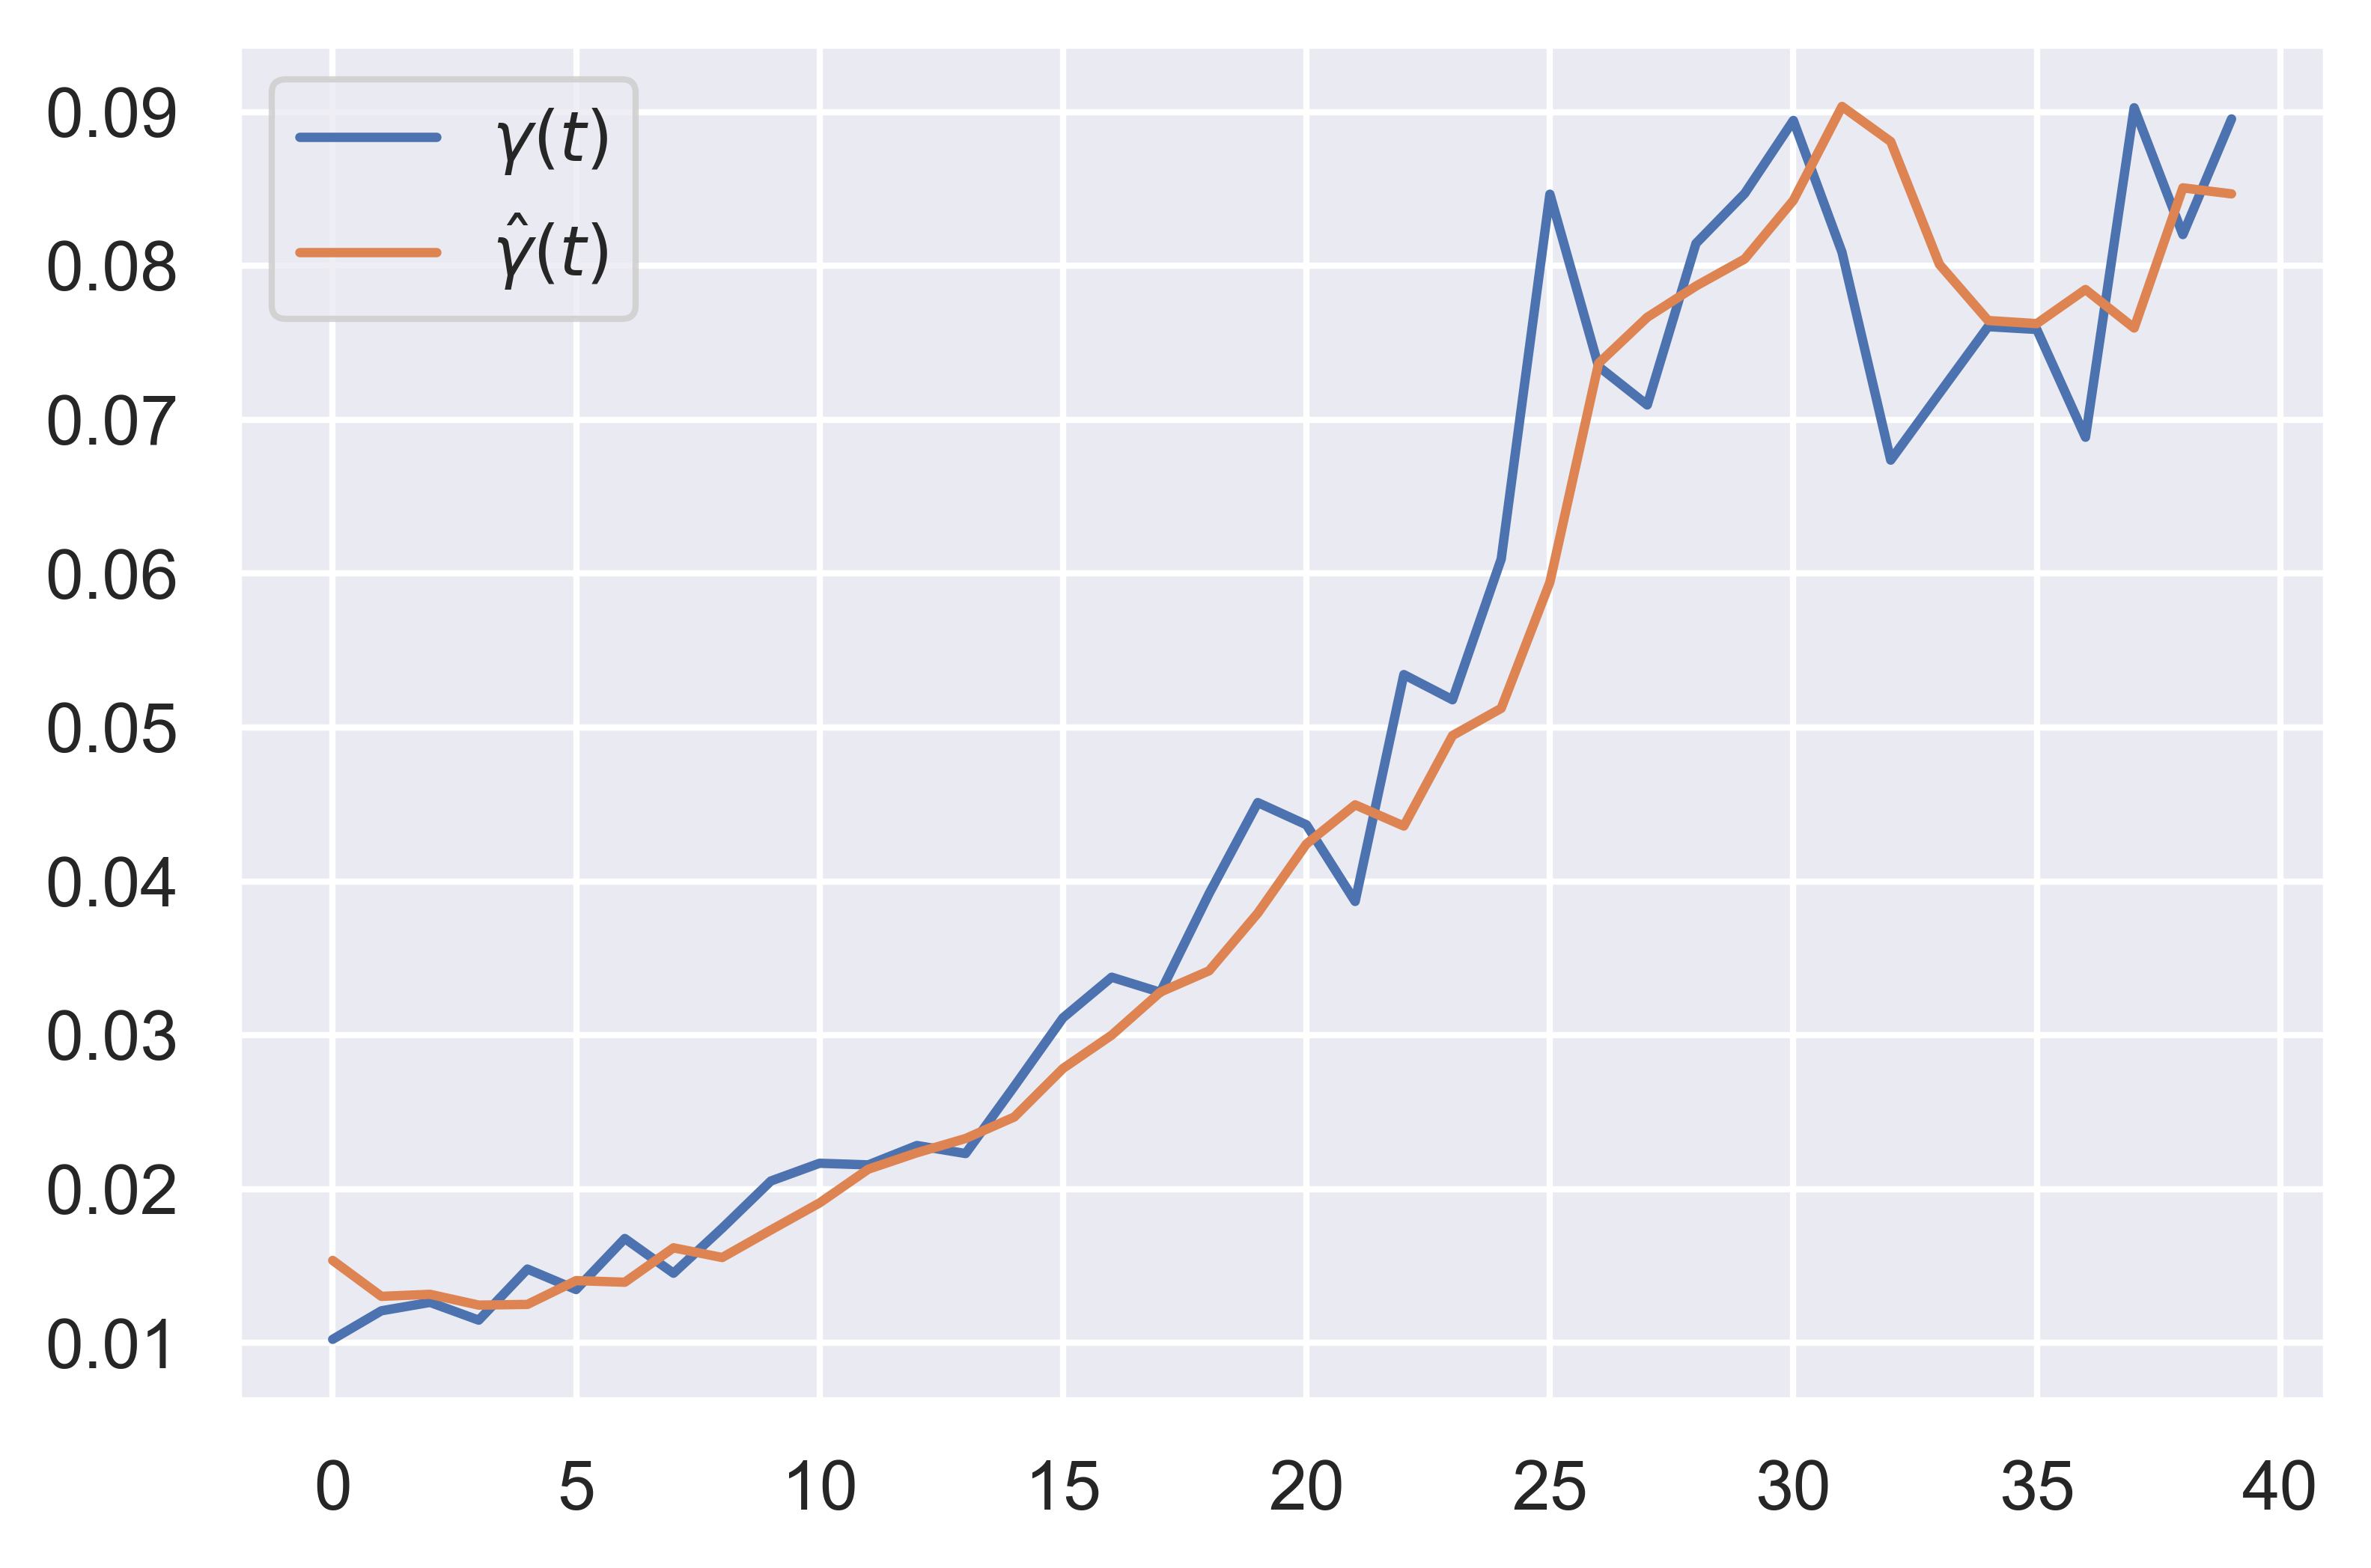

In [8]:
##### Plot the training and testing results #####
plt.figure(1, figsize=(8,4))
plt.plot(y_beta, label=r'$\beta (t)$')
plt.plot(beta_hat, label=r'$\hat{\beta}(t)$')
plt.legend()

plt.figure(2)
plt.plot(y_gamma, label=r'$\gamma (t)$')
plt.plot(gamma_hat, label=r'$\hat{\gamma}(t)$')
plt.legend()

plt.show()

## Time Dependent SIR Model

In [9]:
##### Parameters for the Time-dependent SIR model #####
stop_X = 0 # stopping criteria
stop_day = 120 # maximum iteration days (W in the paper)

day_count = 0
turning_point = 0

S_predict = [S[-1]]
X_predict = [X[-1]]
R_predict = [R[-1]]

predict_beta = np.array(beta[-orders_beta:]).tolist()
predict_gamma = np.array(gamma[-orders_gamma:]).tolist()
while (X_predict[-1] >= stop_X) and (day_count <= stop_day):
    if predict_beta[-1] > predict_gamma[-1]:
        turning_point += 1

    next_beta = clf_beta.predict(np.asarray([predict_beta[-orders_beta:]]))[0]
    next_gamma = clf_gamma.predict(np.asarray([predict_gamma[-orders_gamma:]]))[0]

    if next_beta < 0:
        next_beta = 0
    if next_gamma < 0:
        next_gamma = 0

    predict_beta.append(next_beta)
    predict_gamma.append(next_gamma)

    next_S = ((-predict_beta[-1] * S_predict[-1] *
               X_predict[-1]) / n[-1]) + S_predict[-1]
    next_X = ((predict_beta[-1] * S_predict[-1] * X_predict[-1]) /
              n[-1]) - (predict_gamma[-1] * X_predict[-1]) + X_predict[-1]
    next_R = (predict_gamma[-1] * X_predict[-1]) + R_predict[-1]

    S_predict.append(next_S)
    X_predict.append(next_X)
    R_predict.append(next_R)

    day_count += 1

In [10]:
# Shows progression of predicted reproduction rate (Should be <1 to converge to DFE)
r0_predict = pd.DataFrame({'beta':predict_beta, 'gamma':predict_gamma})
r0_predict['r0'] = r0_predict.beta / r0_predict.gamma
r0_predict['recoverydays'] = 1/r0_predict.gamma
r0_predict.head(10)

,beta,gamma,r0,recoverydays
0,0.001741,0.090271,0.019291,11.077785
1,0.001541,0.082029,0.018783,12.190834
2,0.001542,0.089544,0.017216,11.167665
3,0.001322,0.092041,0.014361,10.864683
4,0.001151,0.093141,0.012361,10.736366
5,0.001012,0.096374,0.010498,10.376226
6,0.000887,0.098997,0.008956,10.101274
7,0.000777,0.101504,0.007653,9.851787
8,0.000681,0.104356,0.006524,9.582560
9,0.000597,0.107192,0.005566,9.329014


In [11]:
########## Print Info ##########
print('\nConfirmed cases tomorrow:', np.rint(X_predict[1] + R_predict[1]))
print('Infected persons tomorrow:', np.rint(X_predict[1]))
print('Recovered + Dead persons tomorrow:', np.rint(R_predict[1]))

print('\nEnd day:', day_count)
print('Confirmed cases on the end day:', np.rint(X_predict[-2] + R_predict[-2]))

print('\nTurning point:', turning_point)


Confirmed cases tomorrow: 81021.0
Infected persons tomorrow: 12373.0
Recovered + Dead persons tomorrow: 68648.0

End day: 91
Confirmed cases on the end day: 81088.0

Turning point: 0


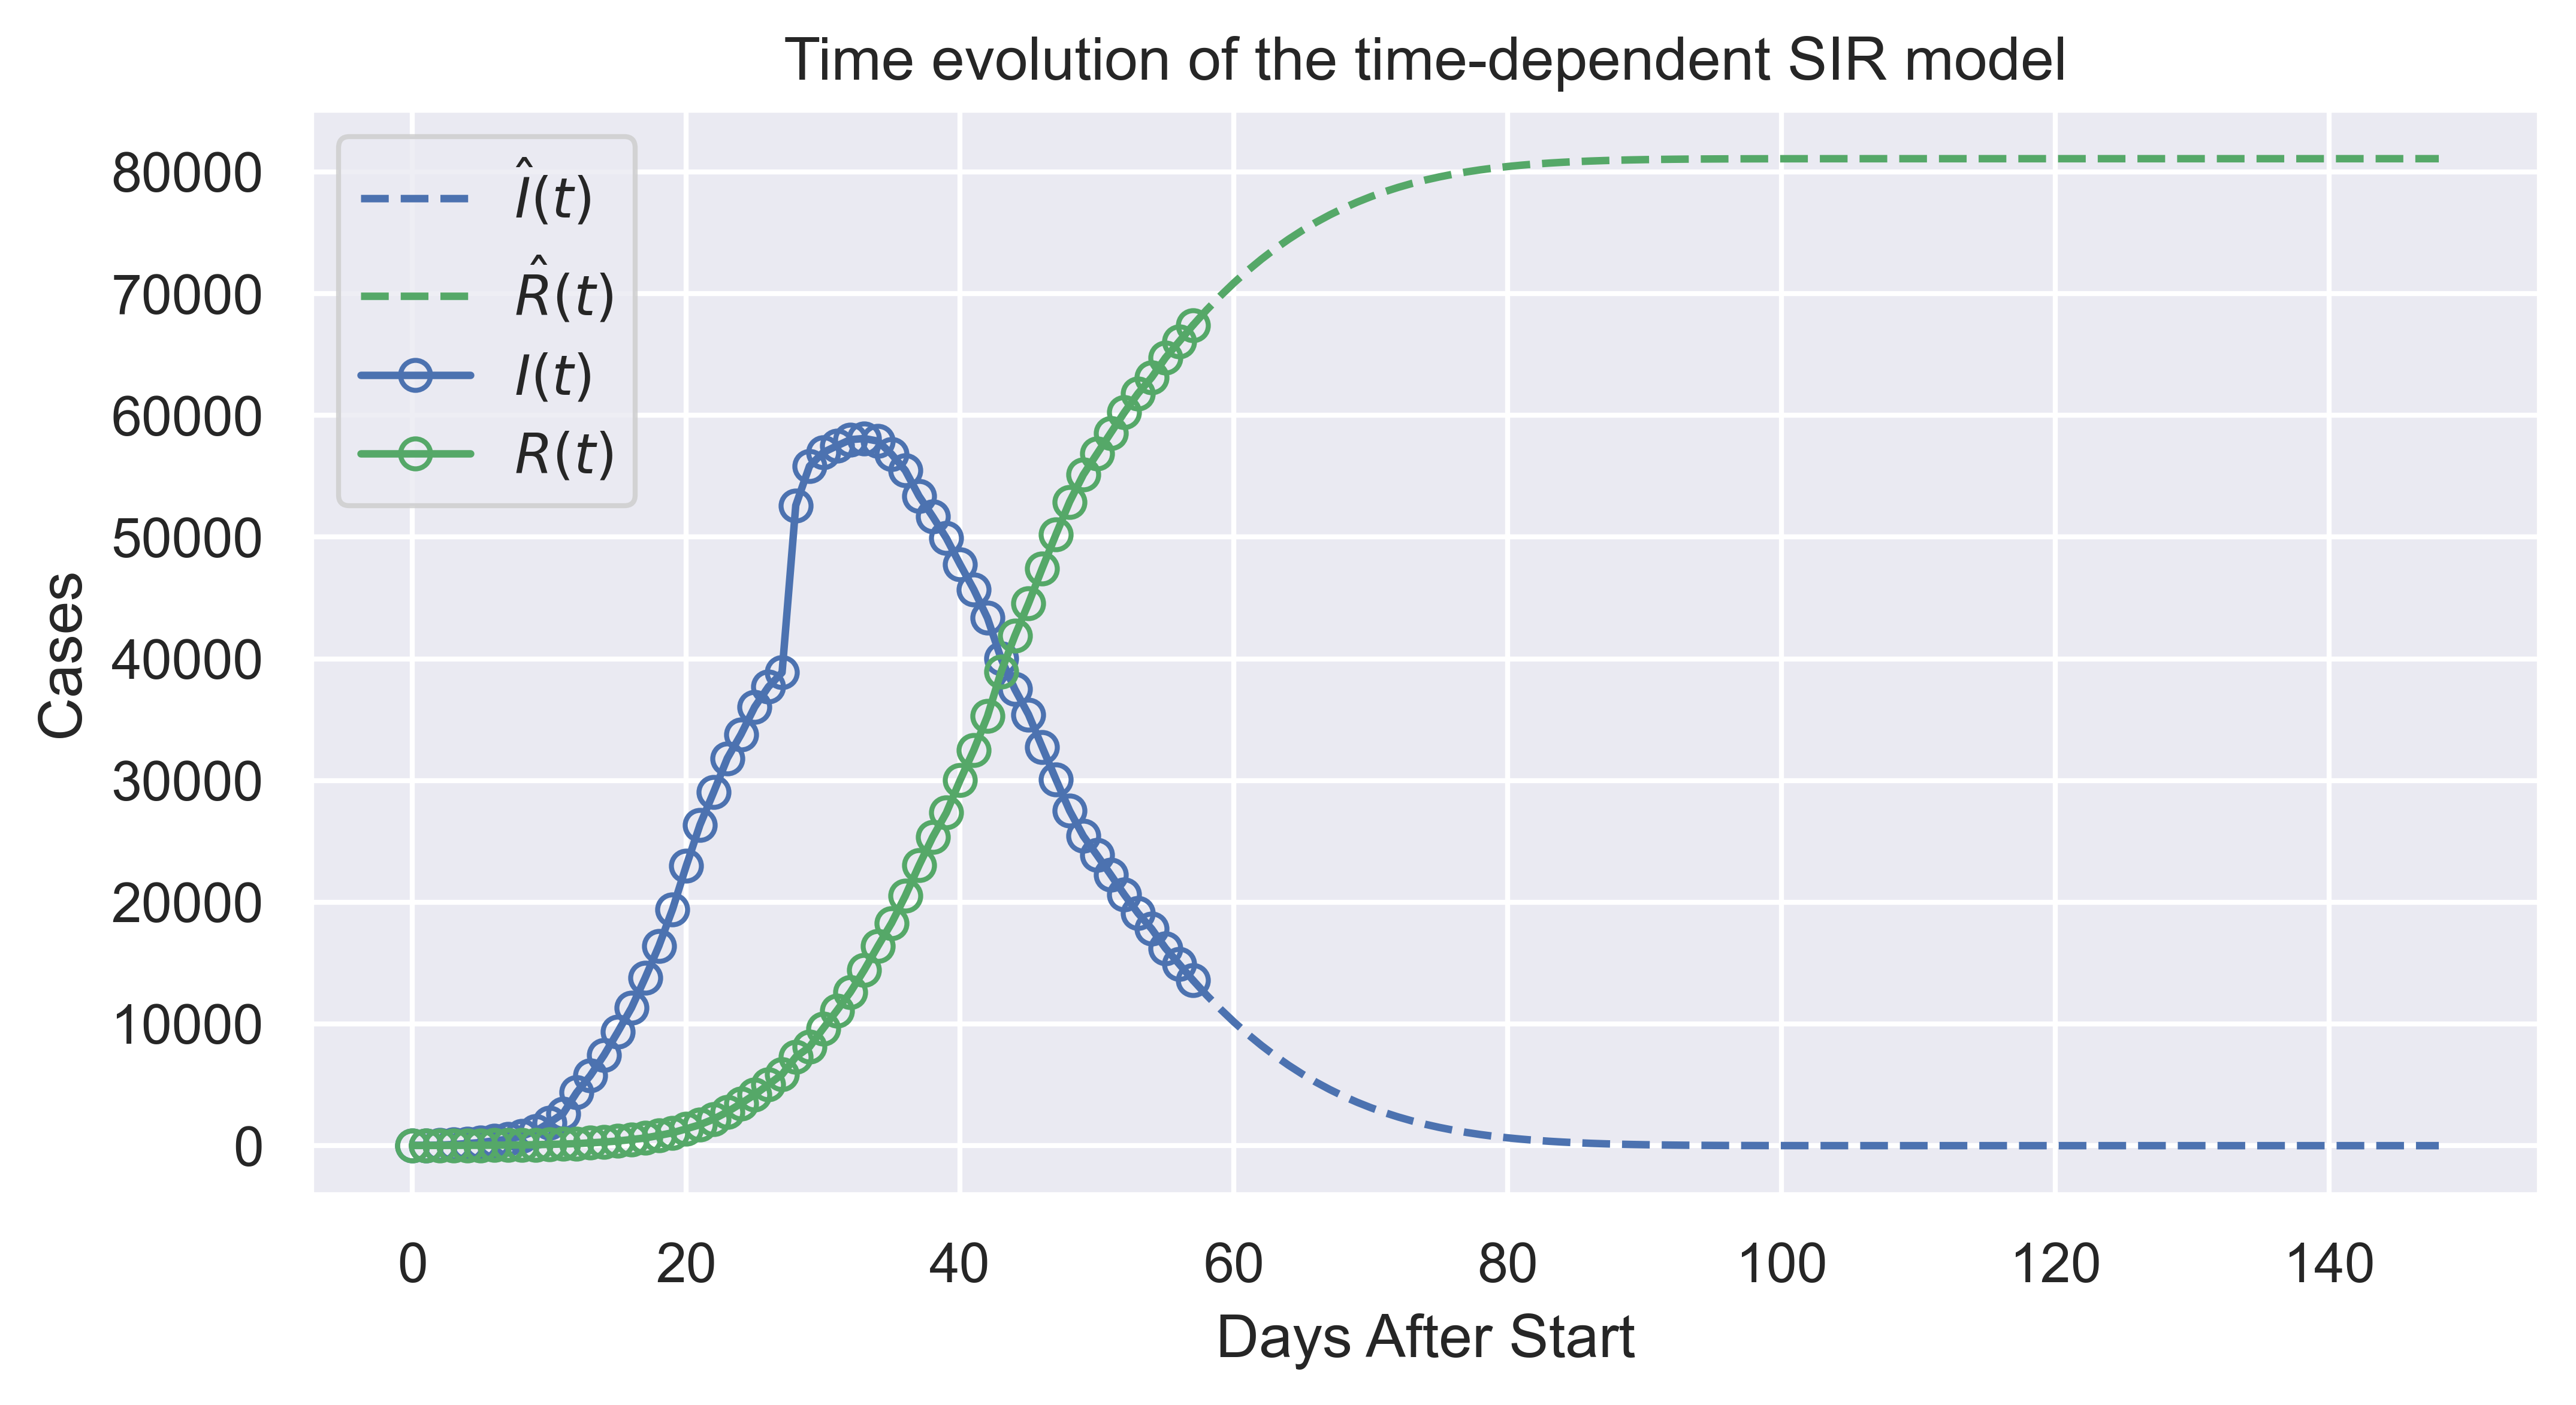

In [12]:
########## Plot the time evolution of the time-dependent SIR model ##########
plt.figure(3, figsize=(8,4))

plt.plot(range(len(X) - 1, len(X) - 1 + len(X_predict)), X_predict, '--', label=r'$\hat{I}(t)$', color='b')
plt.plot(range(len(X) - 1, len(X) - 1 + len(X_predict)), R_predict, '--', label=r'$\hat{R}(t)$', color='g')

plt.plot(range(len(X)), X, 'o-', label=r'$I(t)$', markerfacecolor = 'none', color='b')
plt.plot(range(len(X)), R, 'o-', label=r'$R(t)$', markerfacecolor = 'none', color='g')

# plt.yscale('log')

plt.xlabel('Days After Start')
plt.ylabel('Cases')
plt.title('Time evolution of the time-dependent SIR model')
plt.legend()
plt.show()